In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.linalg
import scipy.optimize
# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [3]:
# Lx = 9
# Ly = 12
mult = 16
Lx = 6*mult
Ly = 3*mult

tau = Ly/Lx*np.exp( 1.0j*np.pi/3 )

Nbintot = 5
binsize = 1e2
# Nbintot = 4
# binsize = 1e2

nskip = 1
Nbin = Nbintot-nskip

In [3]:
class Jackknife:
    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def __init__( self, nbins, binsize, binned ):
        self.binsize = binsize
        self.nbins = nbins
        self.N = self.binsize * self.nbins
        self.binned = binned
        self.jack_avg = []
        self.est = 0
        self.var_est = 0
        
        for i in range( 0, self.nbins ):
            resmpld = np.delete(binned, i, 0)
            self.jack_avg.append( np.mean(resmpld, 0) )
            
        self.do_it()

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)
    
def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+': '+'{num:.{width}f}'.format(num=(exact-cen)/err, width=i+1)+' sigma'

In [4]:
def theta(z, Tau, n=0, nmax=1e5, tol=1.0e-15):
    
    if n==0:
        r = np.pi*1.0j/Tau
        s = np.exp( -r*z**2 )

        s_old = s
        for ell in np.arange(1,nmax):
            s += np.exp( -r*(ell+z)**2 )
            s += np.exp( -r*(-ell+z)**2 )

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = 1.0 / np.sqrt(-1.0j*Tau)
        return coeff * s

    else:

        r = np.pi*1.0j/Tau
        arr = np.full(n+1, 0)
        arr[n]=1
        Hn = np.polynomial.hermite.Hermite( arr )

        coeff = Hn( np.sqrt(r)*z )
        exp = np.exp( -r*z**2 )
        s = coeff * exp

        s_old = s
        for ell in np.arange(1,nmax):
            coeff = Hn( np.sqrt(r)*(ell+z) )
            exp = np.exp( -r*(ell+z)**2 )
            s += coeff * exp

            coeff = Hn( np.sqrt(r)*(-ell+z) )
            exp = np.exp( -r*(-ell+z)**2 )
            s += coeff * exp

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*Tau)

        return coeff * s

In [5]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    return coeff * s

def th3(z, n=0):
    return theta(z, tau, n)

def th4(z, n=0):
    return theta(z+0.5, tau, n)

def Dth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    return s

def Dth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z)
    s += 0.5*coeff * th3(z+0.5*tau, 1)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    return s

def Dth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 2)

def Dth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 2)

def dDth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z, 1)
    s -= 0.5*np.pi*1.0j*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 2)
    s -= np.pi*1.0j/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 3)
    return s

def dDth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z, 1)
    s += 0.5*np.pi*1.0j*coeff * th3(z+0.5*tau, 1)
    s += 0.5*coeff * th3(z+0.5*tau, 2)
    s += np.pi*1.0j/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 3)
    return s

def dDth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 3)

def dDth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 3)

In [6]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

def dP(z):
    coeff = (np.pi * th20*th30)**2
    
    f1 = th4(z) * th4(z,1) / th1(z)**2
    f2 = th4(z)**2 * th1(z,1) / th1(z)**3

    res = 2.0 * coeff * (f1-f2)
    
    return res

def ddP(z):    
    coeff = (np.pi * th20*th30)**2
    
    f1 = ( th4(z,1)**2 + th4(z) * th4(z,2) ) / th1(z)**2
    f2 = th4(z) * th4(z,1) * th1(z,1) / th1(z)**3
    f3 = th4(z)**2 * th1(z,2) / th1(z)**3
    f4 = th4(z)**2 * th1(z,1)**2 / th1(z)**4

    res = 2.0 * coeff * (f1 - 4.0*f2 -f3 + 3.0*f4 )
    
    return res

In [7]:
def P2(z):
    return th1p0/th20 * th2(z)/th1(z)

def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

def P4(z):
    return th1p0/th40 * th4(z)/th1(z)

# def P2Alt(z):
#     return np.sqrt( P(z)-e1 )
# def P3Alt(z):
#     return np.sqrt( P(z)-e2 )
# def P4Alt(z):
#     return np.sqrt( P(z)-e3 )

def dP2(z):
    return th1p0/th20 * ( th2(z,1)/th1(z) - th2(z)*th1(z,1)/th1(z)**2 )

def ddP2(z):
    return th1p0/th20 * ( th2(z,2)/th1(z) - 2.0*th2(z,1)*th1(z,1)/th1(z)**2 - th2(z)*th1(z,2)/th1(z)**2 + 2.0*th2(z)*th1(z,1)**2/th1(z)**3 )

def dP3(z):
    return th1p0/th30 * ( th3(z,1)/th1(z) - th3(z)*th1(z,1)/th1(z)**2 )

def ddP3(z):
    return th1p0/th30 * ( th3(z,2)/th1(z) - 2.0*th3(z,1)*th1(z,1)/th1(z)**2 - th3(z)*th1(z,2)/th1(z)**2 + 2.0*th3(z)*th1(z,1)**2/th1(z)**3 )

def dP4(z):
    return th1p0/th40 * ( th4(z,1)/th1(z) - th4(z)*th1(z,1)/th1(z)**2 )

def ddP4(z):
    return th1p0/th40 * ( th4(z,2)/th1(z) - 2.0*th4(z,1)*th1(z,1)/th1(z)**2 - th4(z)*th1(z,2)/th1(z)**2 + 2.0*th4(z)*th1(z,1)**2/th1(z)**3 )

def DP2(z):
    tmp1 = dDth1(0)/th20 * th2(z)/th1(z)
    tmp2 = -th1p0*Dth2(0)/th20**2 * th2(z)/th1(z)
    tmp3 = th1p0/th20 * Dth2(z)/th1(z)
    tmp4 = -th1p0/th20 * th2(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

def DP3(z):
    tmp1 = dDth1(0)/th30 * th3(z)/th1(z)
    tmp2 = -th1p0*Dth3(0)/th30**2 * th3(z)/th1(z)
    tmp3 = th1p0/th30 * Dth3(z)/th1(z)
    tmp4 = -th1p0/th30 * th3(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

def DP4(z):
    tmp1 = dDth1(0)/th40 * th4(z)/th1(z)
    tmp2 = -th1p0*Dth4(0)/th40**2 * th4(z)/th1(z)
    tmp3 = th1p0/th40 * Dth4(z)/th1(z)
    tmp4 = -th1p0/th40 * th4(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

In [8]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

eta1 = -1.0/6.0 * th1(0, n=3)/th1(0, n=1)

g2 = -4.0 * ( e2*e3 + e3*e1 + e1*e2 )
g3 = 4.0 * e1*e2*e3

In [9]:
def dedekind( t ):
    return np.exp( np.pi*1.0j*t/12.0 ) * theta(0.5*(t+1.0), 3.0*t)

def Ddedekind( t ):
    res = 0.0
    res += np.pi*1.0j/12.0 * dedekind(t)
    res += np.exp( np.pi*1.0j*t/12.0 ) * 0.5 * theta(0.5*(t+1.0), 3.0*t, 1)
    res += np.exp( np.pi*1.0j*t/12.0 ) * 3.0 / (4.0*np.pi*1.0j) * theta(0.5*(t+1.0), 3.0*t, 2)
    return res

# def Ddedekind( t ):
#     res = 0.0
#     res += np.pi*1.0j/12.0 * dedekind(t)
#     res += np.exp( np.pi*1.0j*t/12.0 ) * 0.5 * theta(0.5*(t+1.0), 3.0*t, 1)
#     res += np.exp( np.pi*1.0j*t/12.0 ) * 3.0 / (4.0*np.pi*1.0j) * theta(0.5*(t+1.0), 3.0*t, 2)
#     return res

In [10]:
def zeta(z):
    return th1(z,1)/th1(z) + 2.0*eta1*z

In [11]:
def De1():
    fac = np.pi*1.0j
    tmp = e1**2 - 1.0/6.0 * g2 - 2.0*eta1*e1
    return tmp/fac

def De2():
    fac = np.pi*1.0j
    tmp = e2**2 - 1.0/6.0 * g2 - 2.0*eta1*e2
    return tmp/fac

def De3():
    fac = np.pi*1.0j
    tmp = e3**2 - 1.0/6.0 * g2 - 2.0*eta1*e3
    return tmp/fac

In [12]:
def ZM( nu ):
    eta = dedekind( tau )
    coeff = 1.0/(2.0* np.abs(eta) )

    if nu == 2: res = coeff * np.abs(th20)
    elif nu == 3: res = coeff * np.abs(th30)
    elif nu == 4: res = coeff * np.abs(th40)
    elif nu == 1: res = 0.0
    
    return res

def DZM2():
    eta = dedekind( tau )
    Deta = Ddedekind( tau )
    Dth20 = Dth2(0)
    
    tmp1 = -0.25 * Deta * np.conj(eta) / np.abs(eta)**3 * np.abs( th20 )
    tmp2 = 0.25 * Dth20 * np.conj(th20) / (np.abs(eta)*np.abs(th20))
    
    return tmp1 + tmp2

def DZM3():
    eta = dedekind( tau )
    Deta = Ddedekind( tau )
    Dth30 = Dth3(0)
    
    tmp1 = -0.25 * Deta * np.conj(eta) / np.abs(eta)**3 * np.abs( th30 )
    tmp2 = 0.25 * Dth30 * np.conj(th30) / (np.abs(eta)*np.abs(th30))
    
    return tmp1 + tmp2

def DZM4():
    eta = dedekind( tau )
    Deta = Ddedekind( tau )
    Dth40 = Dth4(0)
    
    tmp1 = -0.25 * Deta * np.conj(eta) / np.abs(eta)**3 * np.abs( th40 )
    tmp2 = 0.25 * Dth40 * np.conj(th40) / (np.abs(eta)*np.abs(th40))
    
    return tmp1 + tmp2

# 2.0*np.pi*1.0j * DZM4()
# -0.25*e3 * ZM(4)

In [13]:
def ZMtot():
    res = 0.0
    for nup in range(1, 5):
        res += ZM(nup)
    return res

def DZMtot():
    return DZM2() + DZM3() + DZM4()

In [14]:
def ZMss_nu(z, nu):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = np.abs( th1(z) )**(1/4)
    
    if nu==1: numer=np.abs( th1(0.5*z) )
    elif nu==2: numer=np.abs( th2(0.5*z) )
    elif nu==3: numer=np.abs( th3(0.5*z) )
    elif nu==4: numer=np.abs( th4(0.5*z) )
    else: assert(false)
    
    return factor * numer/denom


def ss_corr_analytic(z):
    res = 0.0
    for nu in range(1,5):
        res += ZMss_nu( z,nu )

    res /= ZMtot()
    
    return res

def dss_corr_analytic(z):
    res = 0.0

    res += dZMss_nu1( z )
    res += dZMss_nu2( z )
    res += dZMss_nu3( z )
    res += dZMss_nu4( z )

    res /= ZMtot()
    
    return res

def Dss_corr_analytic(z):
    res = 0.0

    res += DZMss_nu1( z )
    res += DZMss_nu2( z )
    res += DZMss_nu3( z )
    res += DZMss_nu4( z )
    res /= ZMtot()

    ztot = ZMtot()
    Dztot = DZMtot()
    
    res -= Dztot/ztot * ss_corr_analytic( z )
    
    return res

# def ss_corr_analytic2(z, wbar):
#     res = 0.0
#     res += ZMss_nu1( z, wbar )
#     res += ZMss_nu2( z, wbar )
#     res += ZMss_nu3( z, wbar )
#     res += ZMss_nu4( z, wbar )

#     res /= ZMtot()
    
#     return res

In [15]:
def eps_1pt_analytic():
    eta = dedekind( tau )
    sumTh = np.abs(th20) + np.abs(th30) + np.abs(th40)
    return 2.0 * np.pi * np.abs(eta)**3 / sumTh

In [16]:
def epseps_corr_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * np.abs( P2(z) )**2
    res += ZM( 3 ) * np.abs( P3(z) )**2
    res += ZM( 4 ) * np.abs( P4(z) )**2

    res /= ZMtot()
    
    return res

def depseps_corr_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * dP2(z)*np.conj(P2(z))
    res += ZM( 3 ) * dP3(z)*np.conj(P3(z))
    res += ZM( 4 ) * dP4(z)*np.conj(P4(z))

    res /= ZMtot()
    
    return res

def Depseps(w1, w2):
    p2 = P2(w1-w2)
    cp2 = np.conj(P2(w1-w2))
    Dp2 = DP2(w1-w2)
    
    p3 = P3(w1-w2)
    cp3 = np.conj(P3(w1-w2))
    Dp3 = DP3(w1-w2)

    p4 = P4(w1-w2)
    cp4 = np.conj(P4(w1-w2))
    Dp4 = DP4(w1-w2)

    ztot = ZMtot()
    Dztot = DZMtot()

    tmp1 = -Dztot/ztot * epseps_corr_analytic(w1-w2)
    
    tmp2 =  0.0   
    tmp2 += DZM2() * p2*cp2 + ZM(2)* Dp2*cp2
    tmp2 += DZM3() * p3*cp3 + ZM(3)* Dp3*cp3
    tmp2 += DZM4() * p4*cp4 + ZM(4)* Dp4*cp4
    tmp2 /= ztot
    
    return tmp1 + tmp2

In [17]:
def ZMss_nu1(z, wbar):
    w = np.conj(wbar)

    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = ( th1(z) * np.conj(th1(w)) )**(1/8)
    
    numer = ( th1(0.5*z) * np.conj(th1(0.5*w)) )**(1/2)

    return factor * numer/denom

def ZMss_nu2(z, wbar):
    w = np.conj(wbar)

    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = ( th1(z) * np.conj(th1(w)) )**(1/8)
    
    numer = ( th2(0.5*z) * np.conj(th2(0.5*w)) )**(1/2)
    
    return factor * numer/denom

def ZMss_nu3(z, wbar):
    w = np.conj(wbar)

    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = ( th1(z) * np.conj(th1(w)) )**(1/8)
    
    numer = ( th3(0.5*z) * np.conj(th3(0.5*w)) )**(1/2)
    
    return factor * numer/denom

def ZMss_nu4(z, wbar):
    w = np.conj(wbar)

    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = ( th1(z) * np.conj(th1(w)) )**(1/8)
    
    numer = ( th4(0.5*z) * np.conj(th4(0.5*w)) )**(1/2)
    
    return factor * numer/denom

In [18]:
def dZMss_nu1(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )

    th1z = th1(z)
    th1H = th1(0.5*z)
    
    dth1z = th1(z, 1)
    dth1H = th1(0.5*z, 1)

    tmp1 = 0.25 * dth1H * np.conj(th1H) / ( np.abs(th1H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th1H ) * dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return factor * (tmp1+tmp2)

def dZMss_nu2(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )

    th1z = th1(z)
    th2H = th2(0.5*z)
    
    dth1z = th1(z, 1)
    dth2H = th2(0.5*z, 1)

    tmp1 = 0.25 * dth2H * np.conj(th2H) / ( np.abs(th2H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th2H ) * dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return factor * (tmp1+tmp2)

def dZMss_nu3(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )

    th1z = th1(z)
    th3H = th3(0.5*z)
    
    dth1z = th1(z, 1)
    dth3H = th3(0.5*z, 1)

    tmp1 = 0.25 * dth3H * np.conj(th3H) / ( np.abs(th3H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th3H ) * dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return factor * (tmp1+tmp2)

def dZMss_nu4(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )

    th1z = th1(z)
    th4H = th4(0.5*z)
    
    dth1z = th1(z, 1)
    dth4H = th4(0.5*z, 1)

    tmp1 = 0.25 * dth4H * np.conj(th4H) / ( np.abs(th4H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th4H ) * dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return factor * (tmp1+tmp2)

def DZMss_nu1(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    Dlnfactor = -1.0/24.0 / th1p0**2 * dDth1(0) * np.conj(th1p0)

    th1z = th1(z)
    th1H = th1(0.5*z)
    
    Dth1z = Dth1(z)
    Dth1H = Dth1(0.5*z)

    tmp0 = Dlnfactor * ZMss_nu(z, 1)
    tmp1 = 0.5 * Dth1H * np.conj(th1H) / ( np.abs(th1H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th1H ) * Dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return tmp0 + factor * (tmp1+tmp2)

def DZMss_nu2(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    Dlnfactor = -1.0/24.0 / th1p0**2 * dDth1(0) * np.conj(th1p0)

    th1z = th1(z)
    th2H = th2(0.5*z)
    
    Dth1z = Dth1(z)
    Dth2H = Dth2(0.5*z)

    tmp0 = Dlnfactor * ZMss_nu(z, 2)
    tmp1 = 0.5 * Dth2H * np.conj(th2H) / ( np.abs(th2H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th2H ) * Dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return tmp0 + factor * (tmp1+tmp2)

def DZMss_nu3(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    Dlnfactor = -1.0/24.0 / th1p0**2 * dDth1(0) * np.conj(th1p0)

    th1z = th1(z)
    th3H = th3(0.5*z)
    
    Dth1z = Dth1(z)
    Dth3H = Dth3(0.5*z)

    tmp0 = Dlnfactor * ZMss_nu(z, 3)
    tmp1 = 0.5 * Dth3H * np.conj(th3H) / ( np.abs(th3H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th3H ) * Dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return tmp0 + factor * (tmp1+tmp2)

def DZMss_nu4(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    Dlnfactor = -1.0/24.0 / th1p0**2 * dDth1(0) * np.conj(th1p0)

    th1z = th1(z)
    th4H = th4(0.5*z)
    
    Dth1z = Dth1(z)
    Dth4H = Dth4(0.5*z)

    tmp0 = Dlnfactor * ZMss_nu(z, 4)
    tmp1 = 0.5 * Dth4H * np.conj(th4H) / ( np.abs(th4H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th4H ) * Dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return tmp0 + factor * (tmp1+tmp2)

In [19]:
def Tss_analytic(w0, w1, w2):

    ss = ss_corr_analytic(w1-w2)
    dss = dss_corr_analytic(w1-w2)

    tmp1 = 1.0/16.0 * ( P(w1-w0) + 2.0*eta1 ) * ss
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dss

    tmp3 = 1.0/16.0 * ( P(w2-w0) + 2.0*eta1 ) * ss
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dss

    tmp5 = 2.0*np.pi*1.0j * Dss_corr_analytic(w1-w2)

    tmp6 = T_1pt_analytic() * ss
    
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6

In [20]:
# def Tepseps_analyticB(w0, w1, w2):

#     epseps = epseps_corr_analytic(w1-w2)
#     depseps = depseps_corr_analytic(w1-w2)

#     tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
#     tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * depseps

#     tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
#     tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * depseps

#     tmp5 = 2.0*np.pi*1.0j * Depseps(w1, w2)

#     tmp6 = T_1pt_analytic() * epseps
    
#     return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6

# def Tepseps_analyticB(w0, w1, w2):

#     epseps = epseps_corr_analytic(w1-w2)
#     depseps = depseps_corr_analytic(w1-w2)

#     tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
#     tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * depseps

#     tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
#     tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * depseps

#     tmp5 = 2.0*np.pi*1.0j * Depseps(w1, w2)

#     tmp6 = T_1pt_analytic() * epseps
    
#     return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6

def Tepseps2_analytic(w0, w1, w2):

    p = P2(w1-w2)
    cp = np.conj(P2(w1-w2))
    dp = dP2(w1-w2)
    Dp = DP2(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e1 * epseps
    
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

def Tepseps3_analytic(w0, w1, w2):

    p = P3(w1-w2)
    cp = np.conj(P3(w1-w2))
    dp = dP3(w1-w2)
    Dp = DP3(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e2 * epseps
    
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

def Tepseps4_analytic(w0, w1, w2):

    p = P4(w1-w2)
    cp = np.conj(P4(w1-w2))
    dp = dP4(w1-w2)
    Dp = DP4(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e3 * epseps
    
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

def Tepseps_analytic(w0, w1, w2):
    res = 0.0
    
    res += ZM( 2 ) * Tepseps2_analytic(w0, w1, w2)
    res += ZM( 3 ) * Tepseps3_analytic(w0, w1, w2)
    res += ZM( 4 ) * Tepseps4_analytic(w0, w1, w2)

    res /= ZMtot()
    
    return res

In [21]:
# res5 = 0.0
# res6 = 0.0

# p = P2(w1-w2)
# cp = np.conj(P2(w1-w2))
# Dp = DP2(w1-w2)
# tmp5 = 2.0*np.pi*1.0j * Dp*cp
# tmp6 = (-0.25*e1)*p*cp
# res5 += ZM(2) * tmp5
# res6 += ZM(2) * tmp6

# p = P3(w1-w2)
# cp = np.conj(P3(w1-w2))
# Dp = DP3(w1-w2)
# tmp5 = 2.0*np.pi*1.0j * Dp*cp
# tmp6 = (-0.25*e2)*p*cp
# res5 += ZM(3) * tmp5
# res6 += ZM(3) * tmp6

# p = P4(w1-w2)
# cp = np.conj(P4(w1-w2))
# Dp = DP4(w1-w2)
# tmp5 = 2.0*np.pi*1.0j * Dp*cp
# tmp6 = (-0.25*e3)*p*cp
# res5 += ZM(4) * tmp5
# res6 += ZM(4) * tmp6

# res5 /= ZMtot()
# res6 /= ZMtot()

# print( res5 + res6 )

# w1 = 0.0
# w2 = 0.5j

# print( 2.0*np.pi*1.0j * Depseps(w1, w2) + T_1pt_analytic()*epseps_corr_analytic(w1-w2) )

# w0 = tau/3.0
# w1 = 0.0
# w2 = 0.5j

In [22]:
def T_1pt_analytic():
    res = 0.0
    
    res += ZM( 2 ) * e1
    res += ZM( 3 ) * e2
    res += ZM( 4 ) * e3

    res /= ZMtot()
    res *= -0.25
    
    return res

In [23]:
def TTconn2(z):
    return -0.25 * ( dP2(z)**2 - ddP2(z)*P2(z) )

def TTconn3(z):
    return -0.25 * ( dP3(z)**2 - ddP3(z)*P3(z) )

def TTconn4(z):
    return -0.25 * ( dP4(z)**2 - ddP4(z)*P4(z) )

def TT_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * (TTconn2(z) + (-0.25*e1)**2 )
    res += ZM( 3 ) * (TTconn3(z) + (-0.25*e2)**2 )
    res += ZM( 4 ) * (TTconn4(z) + (-0.25*e3)**2 )

    res /= ZMtot()
    
    return res

In [24]:
# directory1="./runs/mult"+str(mult)+"/data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu1/"
directory1="./data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu1/"
# directory1="./data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu1_noEOM/"

In [25]:
kappa = 2.0/3.0
cos = np.cos( np.pi/6.0 )
B = cos / ( 1.0 - kappa**2 * cos**2 )
alat = 1.0/Lx

tanhbeta = kappa*cos

alat = 1.0/Lx
r = np.sqrt(3.0/2.0 * np.sqrt(3.0) * alat) # 

## $\sigma\sigma$

In [26]:
Nbintot

4

In [27]:
ss_corr1 = np.array([np.loadtxt(directory1+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])
jk1 = Jackknife( Nbin, binsize, ss_corr1[nskip:] )

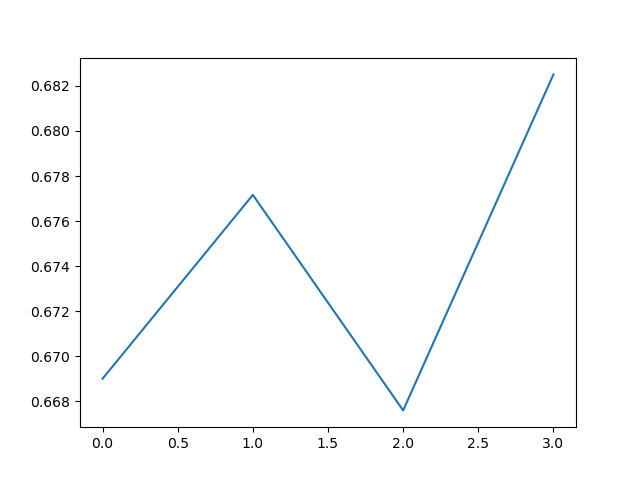

In [28]:
# plt.close()
plt.plot(ss_corr1[:,1,1])
plt.show()

In [29]:
shape = jk1.mean().shape
jkm = jk1.mean()
jke = jk1.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
ss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

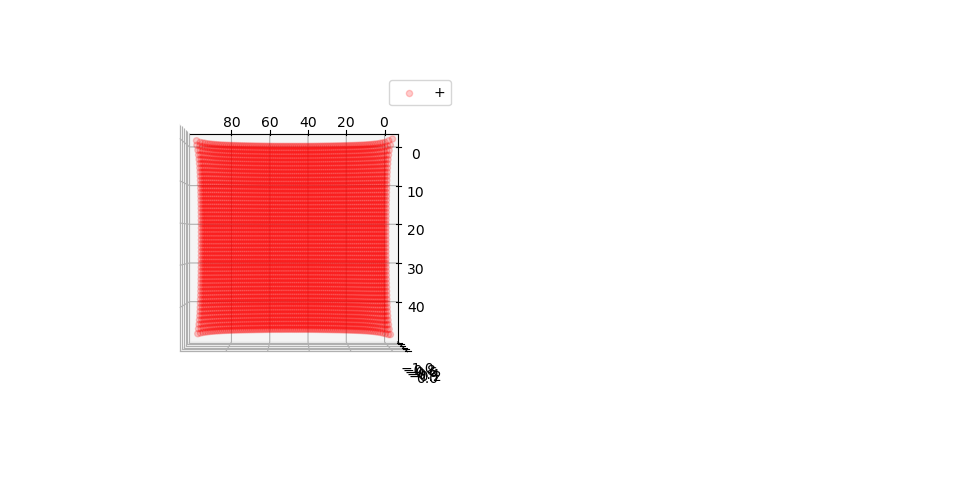

In [30]:
tau = Ly/Lx*np.exp( 1.0j*np.pi/3 ) + 0.5j

# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(ss1.T[0], ss1.T[1], np.log( ss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

plt.show()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# fig.tight_layout()
# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

In [31]:
u = np.sqrt( 3.0/alat**0.25 * 0.5*kappa*B )

In [32]:
t = 0

yt = ss1[t*Lx:(t+1)*Lx]

fac = u**2
# fac = 3.4
# fac = 4.05
# fac = 0.29

In [33]:
np.log( fac * yt.T[2])

array([1.40271112, 1.17768863, 0.95865947, 0.88239325, 0.82462723,
       0.75762633, 0.72241504, 0.6915025 , 0.65413198, 0.63163993,
       0.61118134, 0.58584535, 0.57040164, 0.55558686, 0.54206942,
       0.52994705, 0.51811754, 0.5077622 , 0.49866071, 0.49031903,
       0.48093663, 0.47152044, 0.46470186, 0.45585826, 0.4491457 ,
       0.44236509, 0.43818346, 0.43249663, 0.4269385 , 0.41819452,
       0.41544918, 0.41285981, 0.40573366, 0.40061567, 0.39718115,
       0.39046764, 0.38706994, 0.38438189, 0.38064987, 0.37817425,
       0.37586217, 0.37661327, 0.37718228, 0.37503772, 0.37671015,
       0.37531666, 0.37423688, 0.37656483, 0.37498921, 0.37656483,
       0.37423688, 0.37531666, 0.37671015, 0.37503772, 0.37718228,
       0.37661327, 0.37586217, 0.37817425, 0.38064987, 0.38438189,
       0.38706994, 0.39046764, 0.39718115, 0.40061567, 0.40573366,
       0.41285981, 0.41544918, 0.41819452, 0.4269385 , 0.43249663,
       0.43818346, 0.44236509, 0.4491457 , 0.45585826, 0.46470

(0.25000000000000006+0.4330127018922193j)


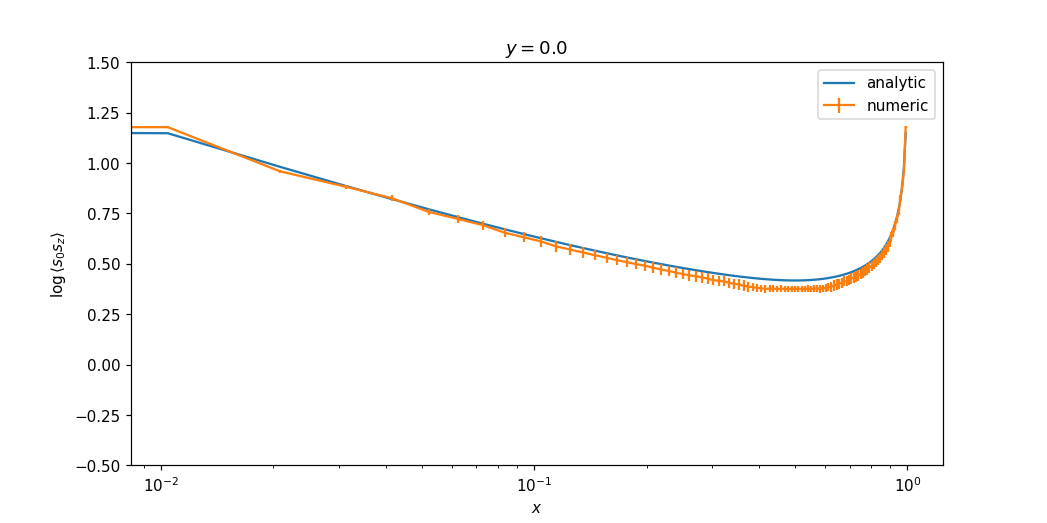

In [36]:
# plt.close()
# tau = Ly/Lx*np.exp( 1.0j*np.pi/3 )
tau = 0.25000000000000006+0.4330127018922193j # + 0.1j
print(tau)

plt.clf()
x = np.arange(0, Lx)/Lx
y = np.array( [ss_corr_analytic( xx ) for xx in x] )
plt.plot( x, np.log(y), label="analytic" )

plt.errorbar( yt.T[0]/Lx, np.log( fac * yt.T[2]), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

plt.legend()
plt.ylim( -0.5, 1.5 )

plt.xscale("log")

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")
plt.savefig('./ss_yslice.pdf',bbox_inches='tight')
plt.show()

In [37]:
t = 0
xt = ss1[t::Lx]
t

0

In [38]:
np.log(fac * xt.T[2])

array([1.40271112, 1.12764588, 0.9587542 , 0.86766514, 0.80022317,
       0.75181824, 0.70843483, 0.67494374, 0.65012351, 0.62709714,
       0.6071697 , 0.59144882, 0.57649871, 0.56180483, 0.55347852,
       0.54372045, 0.5315871 , 0.52553259, 0.51746558, 0.50784717,
       0.50531625, 0.49996753, 0.49826404, 0.50049192, 0.4993786 ,
       0.50049192, 0.49826404, 0.49996753, 0.50531625, 0.50784717,
       0.51746558, 0.52553259, 0.5315871 , 0.54372045, 0.55347852,
       0.56180483, 0.57649871, 0.59144882, 0.6071697 , 0.62709714,
       0.65012351, 0.67494374, 0.70843483, 0.75181824, 0.80022317,
       0.86766514, 0.9587542 , 1.12764588])

In [39]:
np.abs(xt.T[3]/xt.T[2])

array([0.        , 0.00218401, 0.00731673, 0.01023193, 0.01395817,
       0.01890951, 0.02265267, 0.02581941, 0.029039  , 0.03204108,
       0.0328189 , 0.03421678, 0.0343705 , 0.03673528, 0.04024347,
       0.04249501, 0.04451438, 0.04634835, 0.04763689, 0.04880382,
       0.05018208, 0.05224146, 0.0543366 , 0.05362441, 0.05384689,
       0.05362441, 0.0543366 , 0.05224146, 0.05018208, 0.04880382,
       0.04763689, 0.04634835, 0.04451438, 0.04249501, 0.04024347,
       0.03673528, 0.0343705 , 0.03421678, 0.0328189 , 0.03204108,
       0.029039  , 0.02581941, 0.02265267, 0.01890951, 0.01395817,
       0.01023193, 0.00731673, 0.00218401])

In [40]:
tau

(0.25000000000000006+0.4330127018922193j)

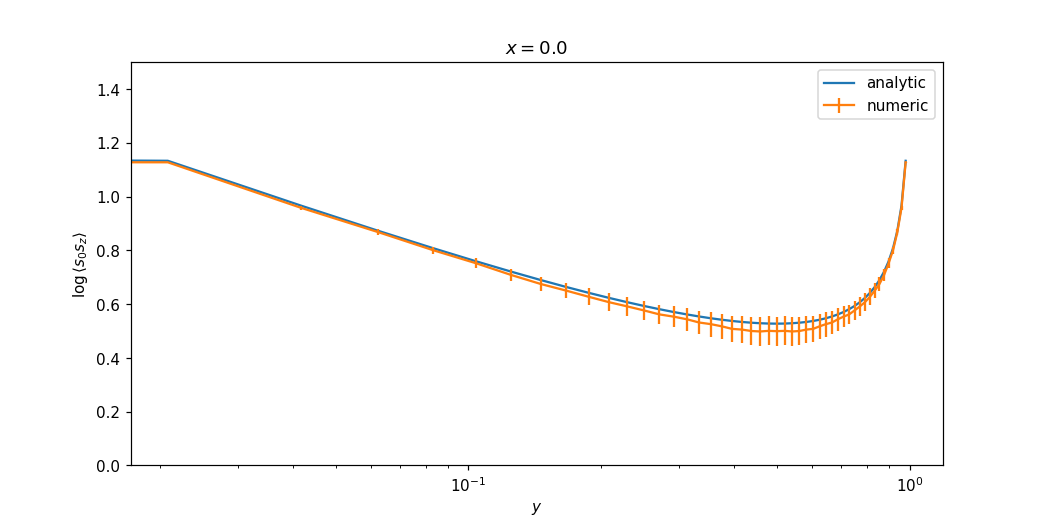

In [41]:
# plt.close()
plt.clf()

# tau = 0.25000000000000006+0.4330127018922193j + 0.08j
tau = 0.25000000000000006+0.4330127018922193j + 0.014j

x = np.arange(0, Ly)/Ly
y = np.array( [ss_corr_analytic( t/Lx + tau*yy ) for yy in x] )

plt.plot( x, np.log(y), label="analytic" )
plt.errorbar( xt.T[1]/Ly, np.log(fac * xt.T[2]), np.abs(xt.T[3]/xt.T[2]), label="numeric" )

plt.legend()
plt.ylim( 0.0, 1.5 )

plt.xscale("log")

plt.title("$x="+str(t/Lx)+"$")
plt.xlabel("$y$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")

plt.savefig('./ss_xslice.pdf',bbox_inches='tight')
plt.show()

## $\varepsilon$

In [42]:
eps_1pt = np.array([np.loadtxt(directory1+"eps_1pt_"+str(i)+".dat") for i in range(1, Nbintot+1)])

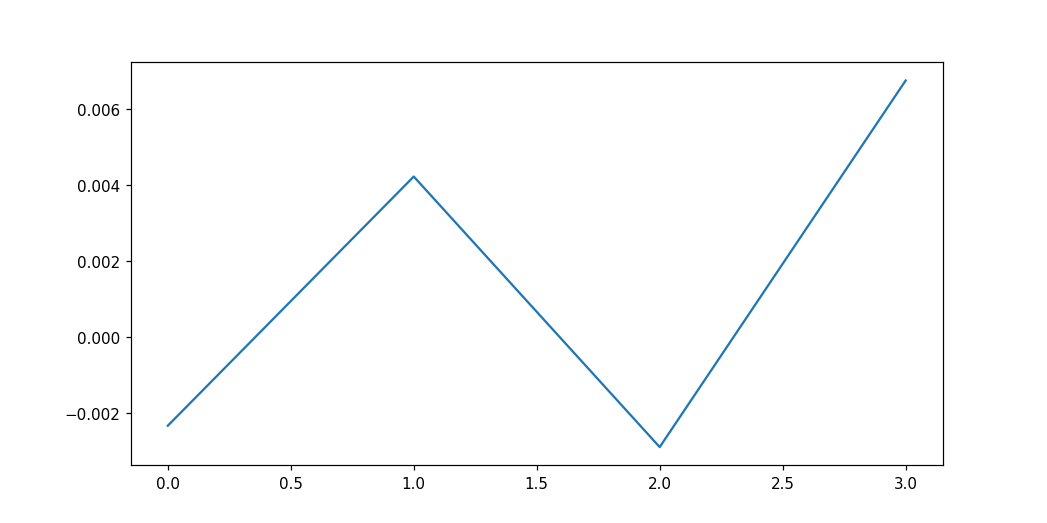

In [43]:
plt.clf()
plt.plot(eps_1pt)
plt.show()

In [44]:
np.mean(eps_1pt)

0.0014347196379136764

In [45]:
# eps1 = 2.0*np.pi/r**2 * (eps_1pt - 1.0)
eps1 = 2.0*np.pi/r**2 * eps_1pt

In [46]:
jk = Jackknife( Nbin, binsize, eps1[nskip:] )

In [47]:
analytic = eps_1pt_analytic()

In [48]:
print( format_print( jk.mean(), jk.err() ) )
print( "exact", analytic )

0.62(67)
exact 1.2648687184315224


In [49]:
tau = 0.25000000000000006+0.4330127018922193j # + 0.014j
analytic = eps_1pt_analytic()
print(analytic)

1.2828455827667882


## $\varepsilon \varepsilon$

In [50]:
epseps_corr1 = np.array([np.loadtxt(directory1+"epseps_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [51]:
epseps = (2.0*np.pi)**2/r**4 * np.array([ epseps_corr1[i] for i in range(Nbintot)])
jk = Jackknife( Nbin, binsize, epseps[nskip:] )

In [52]:
# plt.clf()
# plt.plot(epseps_conn[:,int(Lx/2),int(Lx/2)])
# plt.show()

In [85]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
ss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_160949/2557951700.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(ss1.T[0], ss1.T[1], np.log( ss1.T[2]), c='r', marker='o', label="+", alpha=0.2)


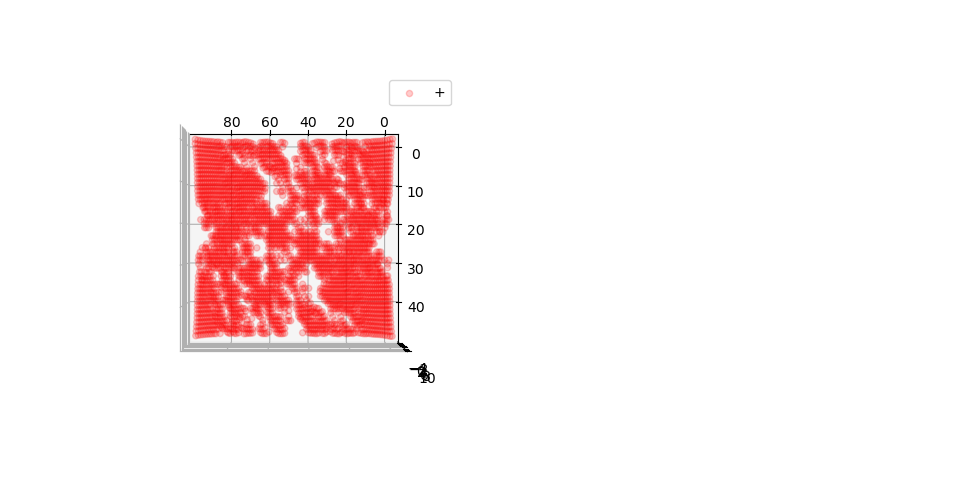

In [86]:
plt.clf()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(ss1.T[0], ss1.T[1], np.log( ss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# fig.tight_layout()
# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')
plt.show()

In [87]:
t = 0
yt = ss1[t*Lx:(t+1)*Lx]

/tmp/ipykernel_160949/978000937.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2] ), np.abs(yt.T[3]/yt.T[2]), label="numeric" )


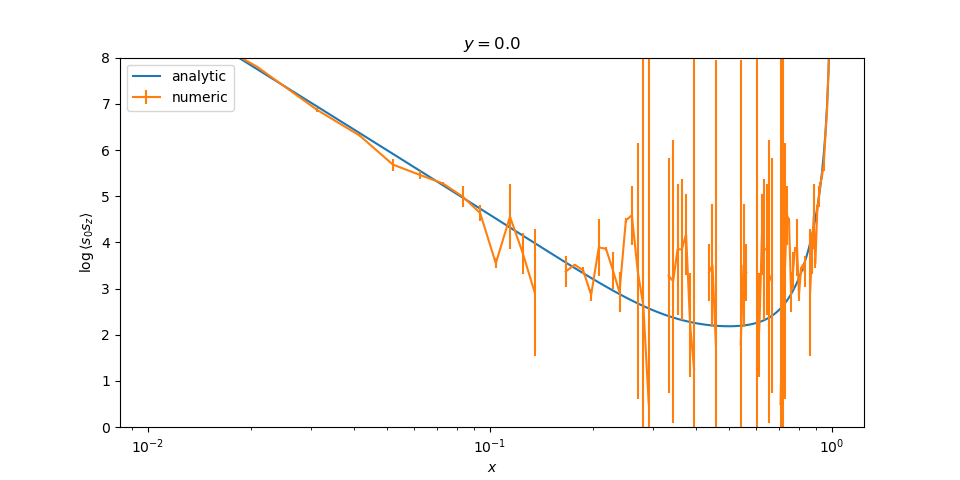

In [88]:
plt.clf()

x = np.arange(0, Lx)/Lx
y = np.array( [epseps_corr_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(y), label="analytic" )

# x = np.arange(0, Lx)/Lx
# y = np.array( [epseps_corr_analytic( xx + tau*t/Ly ) for xx in x] )
# plt.plot( x, np.log(y), label="analytic" )

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2] ), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

plt.legend()
plt.ylim( 0.0, 8.0 )

plt.xscale("log")

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")
plt.show()
# plt.savefig('./yslice.pdf',bbox_inches='tight')

In [89]:
t = 0
xt = ss1[t::Lx]

/tmp/ipykernel_160949/1864417888.py:7: RuntimeWarning: invalid value encountered in log
  plt.errorbar( xt.T[1]/Ly, np.log( xt.T[2] ), np.abs(xt.T[3]/xt.T[2]), label="numeric" )


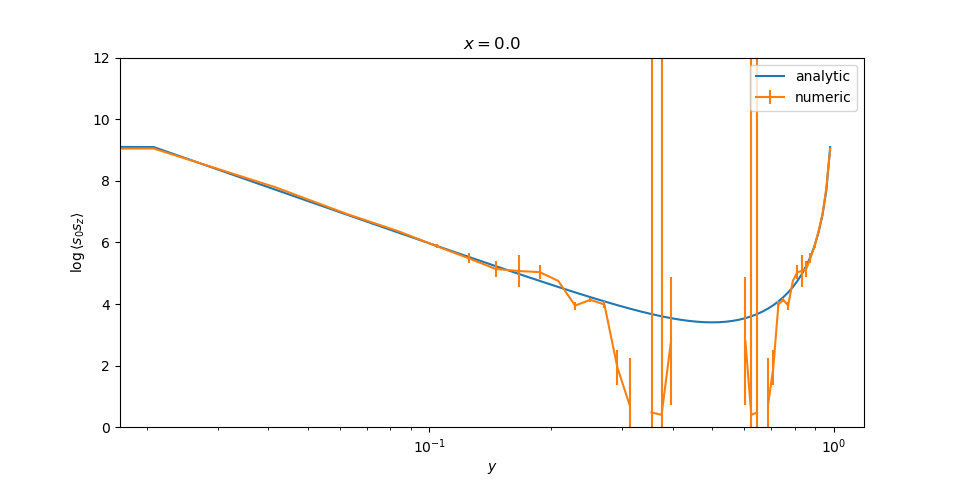

In [90]:
plt.clf()

x = np.arange(0, Ly)/Ly
y = np.array( [epseps_corr_analytic( t/Lx + tau*yy ) for yy in x] )
plt.plot( x, np.log(y), label="analytic" )

plt.errorbar( xt.T[1]/Ly, np.log( xt.T[2] ), np.abs(xt.T[3]/xt.T[2]), label="numeric" )

plt.legend()
# plt.ylim( -1.0, 0.0 )
plt.ylim( 0.0, 12.0 )

plt.xscale("log")

plt.title("$x="+str(t/Lx)+"$")
plt.xlabel("$y$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")

plt.show()
# plt.savefig('./xslice.pdf',bbox_inches='tight')

## $T$

In [94]:
Nbintot = 4
nskip = 1
Nbin = Nbintot-nskip

In [95]:
Txx = np.array([np.loadtxt(directory1+"Txx_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# TxxN = np.array([np.loadtxt(directory1+"TxxN_"+str(i)+".dat") for i in range(1, Nbintot+1)])

Txy = np.array([np.loadtxt(directory1+"Txy_"+str(i)+".dat") for i in range(1, Nbintot+1)])

# Tyy = np.array([np.loadtxt(directory1+"Tyy_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# TyyN = np.array([np.loadtxt(directory1+"TyyN_"+str(i)+".dat") for i in range(1, Nbintot+1)])

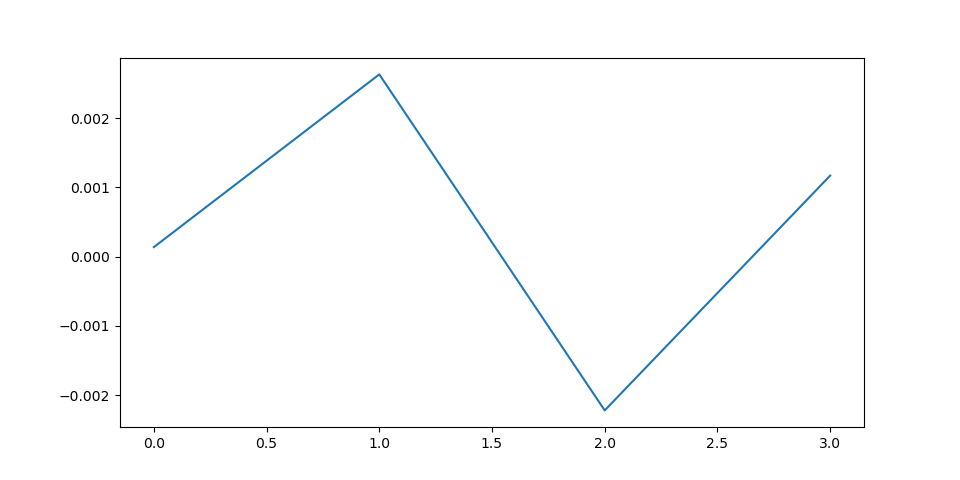

In [96]:
plt.clf()
plt.plot(Txy)
plt.show()

In [97]:
# Tnxx = -(2.0*np.pi) * 1.0/3.0 * (TB+TC-2.0*TA)/alat/r**2
# Tnxy = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (TC-TB)/alat/r**2

In [98]:
Tnxx = (2.0*np.pi) * (Txx)/(alat)/r**2
Tnxy = (2.0*np.pi) * Txy/(alat)/r**2
# Tnyy = (2.0*np.pi) * (Tyy)/(alat)/r**2

In [99]:
jkxx = Jackknife( Nbin, binsize, Tnxx[nskip:] )
jkxy = Jackknife( Nbin, binsize, Tnxy[nskip:] )
# jkyy = Jackknife( Nbin, binsize, Tnyy[nskip:] )

In [100]:
print( format_print( 0.5*jkxx.mean(), 0.5*jkxx.err() ) )

7.6(78)


In [101]:
print( format_print( -0.5*jkxy.mean(), 0.5*jkxy.err() ) )

-6(16)


In [102]:
analy = T_1pt_analytic()

In [103]:
format_print_w_exact( analy.real, 0.5*jkxx.mean(), 0.5*jkxx.err() )

'7.6(78): -1.1 sigma'

In [104]:
print("Re T", format_print_w_exact( analy.real, 0.5*jkxx.mean(), 0.5*jkxx.err() ))
print("Im T", format_print_w_exact( analy.imag, -0.5*jkxy.mean(), 0.5*jkxy.err() ))
# print("Im T", format_print( 0.5*jkyy.mean(), 0.5*jkyy.err() ), -analy.real )

Re T 7.6(78): -1.1 sigma
Im T -6(16): 0 sigma


In [105]:
2.0*np.pi/r**2 * (2.0*np.pi)/(alat)/r**2

5174515.152238339

In [106]:
Ly

48

## TT


In [107]:
tmp = np.array([[ [xx, yy, TT_analytic(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
TT_analy=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [155]:
TxxTxx = np.array([np.loadtxt(directory1+"TxxTxx_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [156]:
iii = Txx.shape[0]
TxxTxx = np.array([TxxTxx[ii] for ii in range(iii)])

In [157]:
jk = Jackknife( Nbin, binsize, TxxTxx[nskip:] )

In [158]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
TxxTxx1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_157347/377274043.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log( TxxTxx1.T[2]), c='r', marker='o', label="+")
/tmp/ipykernel_157347/377274043.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log(-TxxTxx1.T[2]), c='b', marker='o', label="-")
/tmp/ipykernel_157347/377274043.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(2.0*np.real(TT_analy.T[2])),
/tmp/ipykernel_157347/377274043.py:20: RuntimeWarning: invalid value encountered in log
  ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(-2.0*np.real(TT_analy.T[2])),


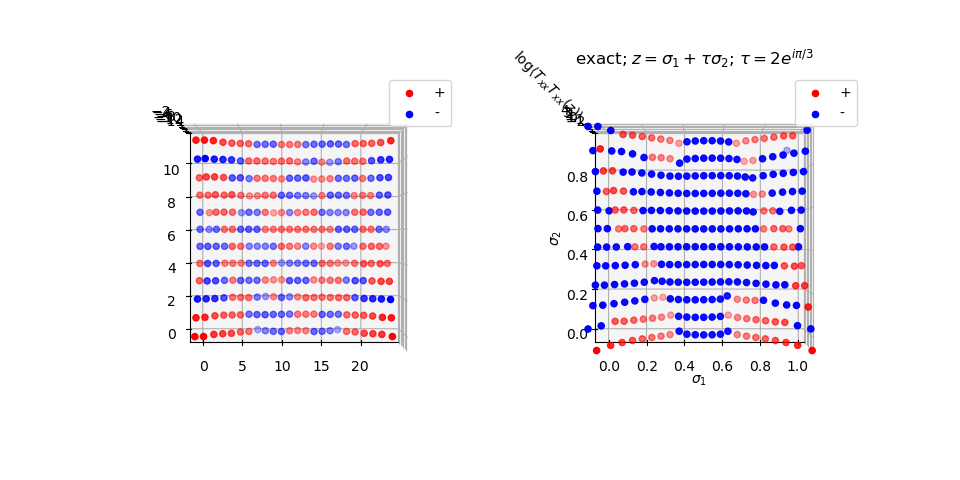

In [172]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log( TxxTxx1.T[2]), c='r', marker='o', label="+")
ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log(-TxxTxx1.T[2]), c='b', marker='o', label="-")
ax.legend()

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(2.0*np.real(TT_analy.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(-2.0*np.real(TT_analy.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

plt.savefig('./TxxTxx.pdf',bbox_inches='tight')

In [160]:
t = 0 #  int(Ly/68)-1
yt = TxxTxx1[t*Lx:(t+1)*Lx]

In [161]:
y

array([1.40416178e+32, 5.81274531e+02, 1.49848532e+02, 7.08946622e+01,
       4.45786824e+01, 3.42558033e+01, 3.14221750e+01, 3.42558033e+01,
       4.45786824e+01, 7.08946622e+01, 1.49848532e+02, 5.81274531e+02])

In [162]:
plt.close()
plt.plot( x, np.log(-np.real(2.0*y)), label="analytic(-)" )

/tmp/ipykernel_157347/2705794930.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log(-np.real(2.0*y)), label="analytic(-)" )


/tmp/ipykernel_157347/1803561552.py:5: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log( np.real(2.0*y) ), label="analytic" )
/tmp/ipykernel_157347/1803561552.py:6: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log(-np.real(2.0*y) ), label="analytic(-)" )
/tmp/ipykernel_157347/1803561552.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/tmp/ipykernel_157347/1803561552.py:13: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


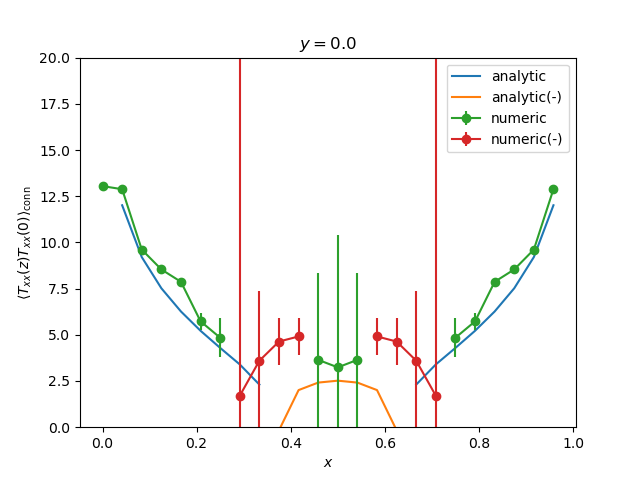

In [164]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [TT_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log( np.real(2.0*y) ), label="analytic" )
plt.plot( x, np.log(-np.real(2.0*y) ), label="analytic(-)" )


fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

plt.savefig('./yslice.pdf',bbox_inches='tight')

In [165]:
TxxTxy = np.array([np.loadtxt(directory1+"TxxTxy_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [166]:
iii = Txx.shape[0]
TxxTxy_conn = np.array([TxxTxy[ii] - Txx[ii]*Txy[ii] for ii in range(iii)])

In [167]:
jk = Jackknife( Nbin, binsize, TxxTxy_conn[nskip:] )

In [168]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
TxxTxy1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_157347/2501957567.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log( TxxTxy1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_157347/2501957567.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log(-TxxTxy1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_157347/2501957567.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(-2.0*np.imag(TT_analy.T[2])),
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.

Text(0.5, 0.92, 'exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$')

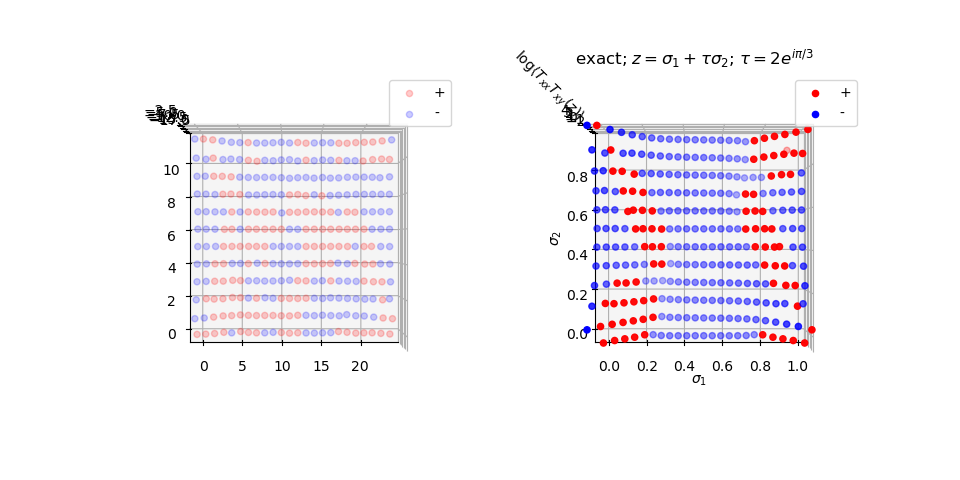

In [169]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log( TxxTxy1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log(-TxxTxy1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(-2.0*np.imag(TT_analy.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(2.0*np.imag(TT_analy.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xy}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

In [170]:
t = 0 #  int(Ly/68)-1
yt = TxxTxy1[t*Lx:(t+1)*Lx]

/tmp/ipykernel_157347/2016396422.py:5: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log(-2.0*np.imag(y)), label="analytic" )
/tmp/ipykernel_157347/2016396422.py:6: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log( 2.0*np.imag(y)), label="analytic" )
/tmp/ipykernel_157347/2016396422.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/tmp/ipykernel_157347/2016396422.py:13: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


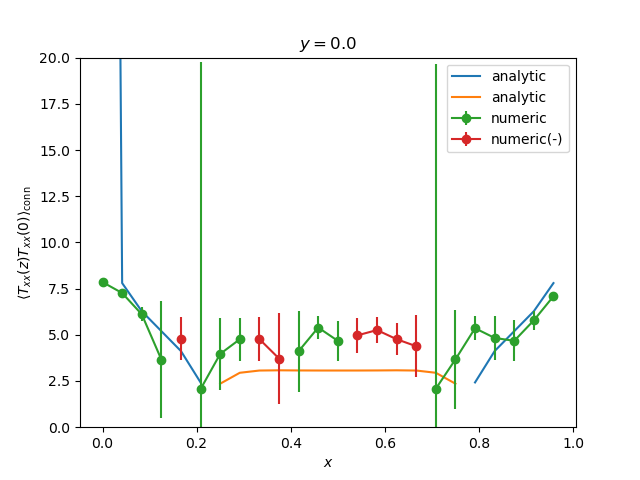

In [171]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [TT_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(-2.0*np.imag(y)), label="analytic" )
plt.plot( x, np.log( 2.0*np.imag(y)), label="analytic" )


fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

# plt.savefig('./yslice.pdf',bbox_inches='tight')

## Tss

In [108]:
Txxss = np.array([np.loadtxt(directory1+"Txx_ss_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [109]:
iii = Txxss.shape[0]
Txxss = np.array([Txxss[ii] for ii in range(iii)])

In [110]:
w1 = (2.0*np.pi) / alat / r**2
# w2 = (2.0*np.pi) / r**2
u = np.sqrt( 3.0/alat**0.25 * 0.5*kappa*B )
ww = w1 * u**2

In [111]:
jk = Jackknife( Nbin, binsize, Txxss[nskip:] )

In [112]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Txxss1=ww * np.array(np.split(tmp2, tmp2.shape[0]/4))

In [113]:
tmp = np.array([[ [xx, yy, Tss_analytic(xx+tau*yy, 0.5*(1.0+tau), 0.0) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
Tss_analy=np.array(np.split(tmp2, tmp2.shape[0]/3))

KeyboardInterrupt: 

In [ ]:
# tmp = np.array([[ [xx, yy, Tss_analytic(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp2 = tmp.flatten()
# Tss_analy=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [ ]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log( Txxss1.T[2]), c='r', marker='o', label="+")
ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log(-Txxss1.T[2]), c='b', marker='o', label="-")
ax.legend()
ax.set_zlim(-2, 6)

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tss_analy.T[0], Tss_analy.T[1], np.log( 2.0*np.real(Tss_analy.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(Tss_analy.T[0], Tss_analy.T[1], np.log(-2.0*np.real(Tss_analy.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 6)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

# plt.savefig('./Txxss.pdf',bbox_inches='tight')

In [123]:
t = 0 #  int(Ly/68)-1
yt = Txxss1[t*Lx:(t+1)*Lx]

In [124]:
yt.T[0]

array([    0.        ,  4005.20884469,  8010.41768937, 12015.62653406,
       16020.83537875, 20026.04422344, 24031.25306812, 28036.46191281,
       32041.6707575 , 36046.87960219, 40052.08844687, 44057.29729156,
       48062.50613625, 52067.71498094, 56072.92382562, 60078.13267031,
       64083.341515  , 68088.55035969, 72093.75920437, 76098.96804906,
       80104.17689375, 84109.38573844, 88114.59458312, 92119.80342781])

In [125]:
yt.T[0]/Lx

array([   0.        ,  166.88370186,  333.76740372,  500.65110559,
        667.53480745,  834.41850931, 1001.30221117, 1168.18591303,
       1335.0696149 , 1501.95331676, 1668.83701862, 1835.72072048,
       2002.60442234, 2169.48812421, 2336.37182607, 2503.25552793,
       2670.13922979, 2837.02293165, 3003.90663352, 3170.79033538,
       3337.67403724, 3504.5577391 , 3671.44144096, 3838.32514283])

/tmp/ipykernel_141759/3147029584.py:6: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log(np.real(2.0*y)), label="analytic (+)" )
/tmp/ipykernel_141759/3147029584.py:7: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log(-np.real(2.0*y)), label="analytic (-)" )
/tmp/ipykernel_141759/3147029584.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( x, np.log( yt.T[2] ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/tmp/ipykernel_141759/3147029584.py:13: RuntimeWarning: invalid value encountered in log
  plt.errorbar( x, np.log( -yt.T[2] ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


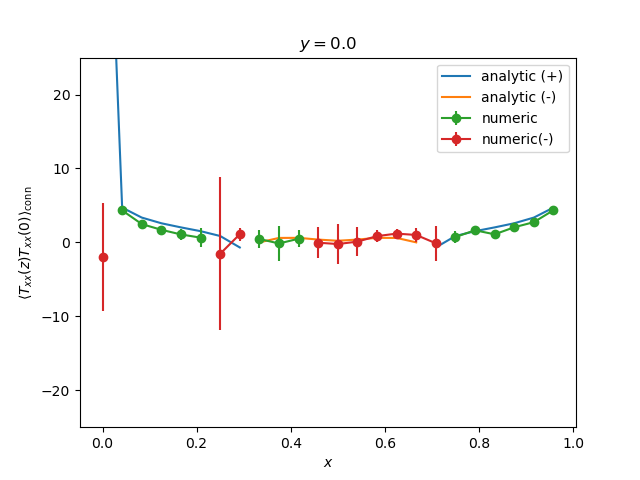

In [126]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [Tss_analytic( xx + tau*t/Ly, 0.5*(1.0+tau), 0.0 ) for xx in x] )

plt.plot( x, np.log(np.real(2.0*y)), label="analytic (+)" )
plt.plot( x, np.log(-np.real(2.0*y)), label="analytic (-)" )

# fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( x, np.log( yt.T[2] ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( x, np.log( -yt.T[2] ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( -25.0, 25.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

# plt.savefig('./yslice.pdf',bbox_inches='tight')

## Tepseps

In [127]:
# tmp = np.array([[ [xx, yy, Tepseps_analytic(0.0, 0.5+1/Lx, xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp2 = tmp.flatten()
# Tepseps_analy=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [136]:
tmp = np.array([[ [xx, yy, Tepseps_analytic(xx+tau*yy, 0.5*(1.0+tau), 0.0) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
Tepseps_analy=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [137]:
w1 = (2.0*np.pi) / alat / r**2
w2 = (2.0*np.pi) / r**2
ww = w1 * w2**2

In [138]:
Txxepseps = np.array([np.loadtxt(directory1+"Txx_epseps_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [139]:
iii = Txxepseps.shape[0]
Txxepseps = ww*np.array([Txxepseps[ii] for ii in range(iii)])

In [140]:
jk = Jackknife( Nbin, binsize, Txxepseps[nskip:] )

In [141]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Txxepseps1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_10993/763042687.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxepseps1.T[0], Txxepseps1.T[1], np.log( Txxepseps1.T[2]), c='r', marker='o', label="+")
/tmp/ipykernel_10993/763042687.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxepseps1.T[0], Txxepseps1.T[1], np.log(-Txxepseps1.T[2]), c='b', marker='o', label="-")
/tmp/ipykernel_10993/763042687.py:20: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps_analy.T[0], Tepseps_analy.T[1], np.log( 2.0*np.real(Tepseps_analy.T[2])),
/tmp/ipykernel_10993/763042687.py:22: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps_analy.T[0], Tepseps_analy.T[1], np.log(-2.0*np.real(Tepseps_analy.T[2])),


Text(0.5, 0.92, 'exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$')

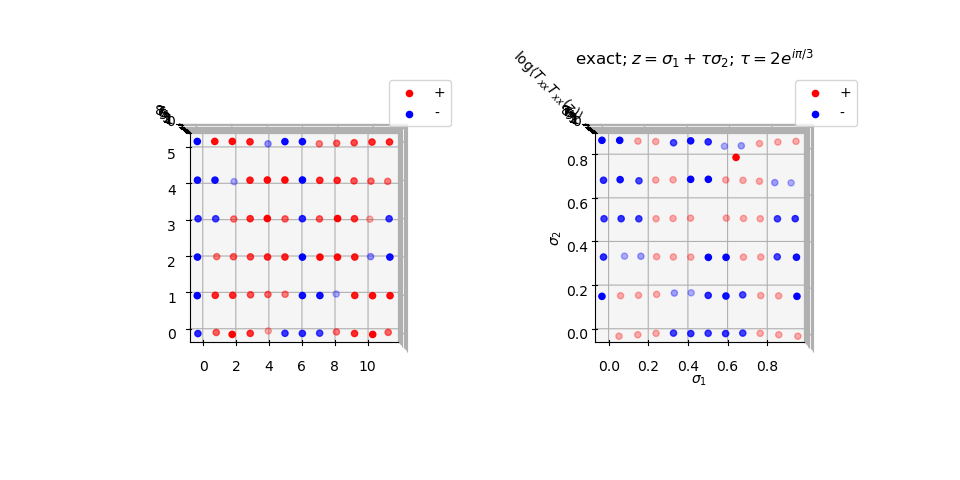

In [142]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Txxepseps1.T[0], Txxepseps1.T[1], np.log( Txxepseps1.T[2]), c='r', marker='o', label="+")
ax.scatter(Txxepseps1.T[0], Txxepseps1.T[1], np.log(-Txxepseps1.T[2]), c='b', marker='o', label="-")
ax.legend()

ax.set_zlim(0, 8)

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps_analy.T[0], Tepseps_analy.T[1], np.log( 2.0*np.real(Tepseps_analy.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(Tepseps_analy.T[0], Tepseps_analy.T[1], np.log(-2.0*np.real(Tepseps_analy.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(0, 8)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

# plt.savefig('./Txxss.pdf',bbox_inches='tight')

In [143]:
Txyepseps = np.array([np.loadtxt(directory1+"Txy_epseps_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [144]:
iii = Txyepseps.shape[0]
Txyepseps = ww*np.array([Txyepseps[ii] for ii in range(iii)])

In [145]:
jk = Jackknife( Nbin, binsize, Txyepseps[nskip:] )

In [146]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Txyepseps1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_10993/3059560893.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txyepseps1.T[0], Txyepseps1.T[1], np.log( Txyepseps1.T[2]), c='r', marker='o', label="+")
/tmp/ipykernel_10993/3059560893.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txyepseps1.T[0], Txyepseps1.T[1], np.log(-Txyepseps1.T[2]), c='b', marker='o', label="-")
/tmp/ipykernel_10993/3059560893.py:20: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps_analy.T[0], Tepseps_analy.T[1], np.log(-2.0*np.imag(Tepseps_analy.T[2])),
/tmp/ipykernel_10993/3059560893.py:22: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps_analy.T[0], Tepseps_analy.T[1], np.log( 2.0*np.imag(Tepseps_analy.T[2])),


Text(0.5, 0.92, 'exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$')

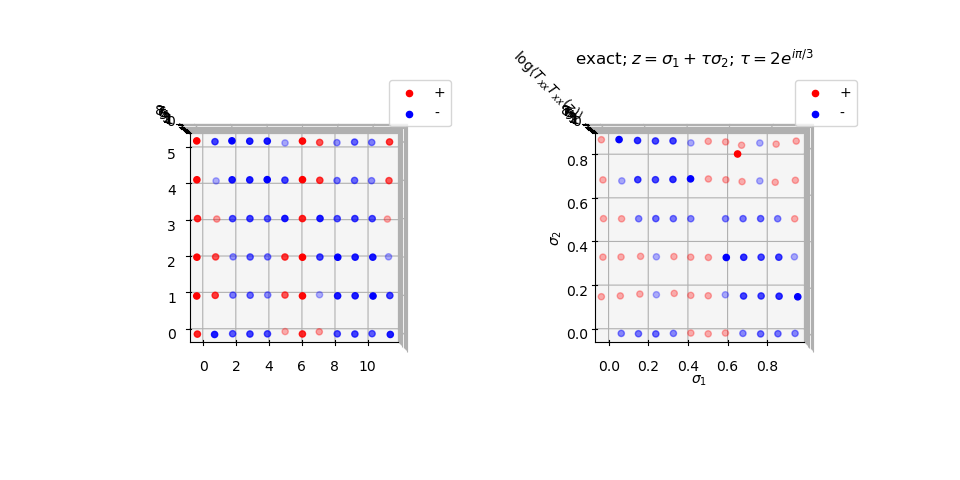

In [147]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Txyepseps1.T[0], Txyepseps1.T[1], np.log( Txyepseps1.T[2]), c='r', marker='o', label="+")
ax.scatter(Txyepseps1.T[0], Txyepseps1.T[1], np.log(-Txyepseps1.T[2]), c='b', marker='o', label="-")
ax.legend()

ax.set_zlim(0, 8)

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps_analy.T[0], Tepseps_analy.T[1], np.log(-2.0*np.imag(Tepseps_analy.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(Tepseps_analy.T[0], Tepseps_analy.T[1], np.log( 2.0*np.imag(Tepseps_analy.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(0, 8)

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

# plt.savefig('./Txxss.pdf',bbox_inches='tight')

## TT sing

In [ ]:
# def ZI( nu ):
#     res = 0.0
    
#     for nup in range(1, 5):
#         if nup == nu: continue
#         else: res += ZM(nup)

#     res -= ZM(nu)
#     res *= 0.5
    
#     return res

In [25]:
def TT2sing(z):
    return 1.0/24.0 * ddP(z) + 2.0*(-0.25*e1)*P(z)

def TT3sing(z):
    return 1.0/24.0 * ddP(z) + 2.0*(-0.25*e2)*P(z)

def TT4sing(z):
    return 1.0/24.0 * ddP(z) + 2.0*(-0.25*e3)*P(z)

def TTsing(z):
    return 1.0/24.0 * ddP(z) + 2.0*T_1pt_analytic()*P(z)

def TTsing_v2(z):
    res = 0.0
    
    res += ZM( 2 ) * TT2sing(z)
    res += ZM( 3 ) * TT3sing(z)
    res += ZM( 4 ) * TT4sing(z)

    res /= ZMtot()
    
    return res

# def TT2sing(z):
#     return 1.0/24.0 * ddP(z) + 2.0*(0.25*e1)*P(z)

# def TT3sing(z):
#     return 1.0/24.0 * ddP(z) + 2.0*(0.25*e2)*P(z)

# def TT4sing(z):
#     return 1.0/24.0 * ddP(z) + 2.0*(0.25*e3)*P(z)

In [37]:
# def TTconn2Alt(z):
#     z = zz
#     c1 = 2.0*np.pi*1.0j* ( -0.25*De1() ) 
#     c2 = 1.0/24.0 * ddP(z)
#     c3 = 2.0*(-0.25*e1) * ( P(z) + 2.0*eta1 )
#     return c1+c2+c3

# def TTconn3Alt(z):
#     z = zz
#     c1 = 2.0*np.pi*1.0j* ( -0.25*De2() ) 
#     c2 = 1.0/24.0 * ddP(z)
#     c3 = 2.0*(-0.25*e2) * ( P(z) + 2.0*eta1 )
#     return c1+c2+c3

# def TTconn4Alt(z):
#     z = zz
#     c1 = 2.0*np.pi*1.0j* ( -0.25*De3() ) 
#     c2 = 1.0/24.0 * ddP(z)
#     c3 = 2.0*(-0.25*e3) * ( P(z) + 2.0*eta1 )
#     return c1+c2+c3

In [39]:
zz=0.43+0.238*1.0j
zz=0.1 + 0.1j

In [42]:
# def Teps_sing(z):
#     res = 0.0
#     res += 0.5 * ( P(z) + 2.0*eta1 ) * eps_1pt_analytic()
#     return res

# def Deps_1pt_analytic():
#     eta = dedekind(tau)
#     Deta = Ddedekind(tau)

#     DAbsEta = 0.5 * Deta * np.conj(eta) / np.abs(eta)

#     DAbsTh2 = 0.5 * Dth2(0) * np.conj(th20) / np.abs(th20)
#     DAbsTh3 = 0.5 * Dth3(0) * np.conj(th30) / np.abs(th30)
#     DAbsTh4 = 0.5 * Dth4(0) * np.conj(th40) / np.abs(th40)

#     sumAbsTh = np.abs(th20) + np.abs(th30) + np.abs(th40)
#     sumDAbsTh = DAbsTh2 + DAbsTh3 + DAbsTh4

#     f1 = 2.0*np.pi * eta**3 * sumDAbsTh / sumAbsTh**2
#     f2 = 6.0*np.pi * eta**2 * DAbsEta / sumAbsTh

#     return 2.0*np.pi*1.0j* (-f1 + f2)

In [ ]:
[ TTsing(xx) - TTsing_v2(xx) for xx in np.arange(0.1, 1.0, 0.1)]
[ TTconn4(xx) - TT4sing(xx) for xx in np.arange(0.1, 1.0, 0.1)]

r2 = 2.0*np.pi*1.0j * (-0.25*De1() ) + 4.0*(-0.25*e1)*eta1
r3 = 2.0*np.pi*1.0j * (-0.25*De2() ) + 4.0*(-0.25*e2)*eta1
r4 = 2.0*np.pi*1.0j * (-0.25*De3() ) + 4.0*(-0.25*e3)*eta1

f2 = r2 + (-0.25*e1)**2
f3 = r3 + (-0.25*e2)**2
f4 = r4 + (-0.25*e3)**2

numer = ZM(2)*f2 + ZM(3)*f3 + ZM(4)*f4
denom = ZMtot()

numer/denom

[ TT_analytic(xx) - TTsing(xx) for xx in np.arange(0.1, 1.0, 0.1)]

## $T \varepsilon$

In [124]:
Txxeps = np.array([np.loadtxt(directory1+"Txx_eps_"+str(i)+".dat") for i in range(1, Nbintot+1)])

FileNotFoundError: ./data_Lx12Ly6nu1/Txx_eps_1.dat not found.

In [125]:
iii = Txxeps.shape[0]
Txxeps = np.array([Txxeps[ii] for ii in range(iii)])

NameError: name 'Txxeps' is not defined

In [126]:
jk = Jackknife( Nbin, binsize, Txxeps[nskip:] )

NameError: name 'Txxeps' is not defined

In [127]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Txxeps1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [128]:
2.0*np.pi/r**2 * (2.0*np.pi)/(alat)/r**2

10106.474906715504

In [113]:
tmp = np.array([[ [xx, yy, Teps_sing(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
Teps_sing1=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [114]:
Teps_L0 = Deps_1pt_analytic()

/tmp/ipykernel_9834/1262122476.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxeps1.T[0], Txxeps1.T[1], np.log( Txxeps1.T[2]), c='r', marker='o', label="+")
/tmp/ipykernel_9834/1262122476.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxeps1.T[0], Txxeps1.T[1], np.log(-Txxeps1.T[2]), c='b', marker='o', label="-")
/tmp/ipykernel_9834/1262122476.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(Teps_sing1.T[0], Teps_sing1.T[1], np.log(np.real(Teps_sing1.T[2] + Teps_L0)),
/tmp/ipykernel_9834/1262122476.py:20: RuntimeWarning: invalid value encountered in log
  ax.scatter(Teps_sing1.T[0], Teps_sing1.T[1], np.log(-np.real(Teps_sing1.T[2] + Teps_L0)),


Text(0.5, 0.92, 'sing; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$')

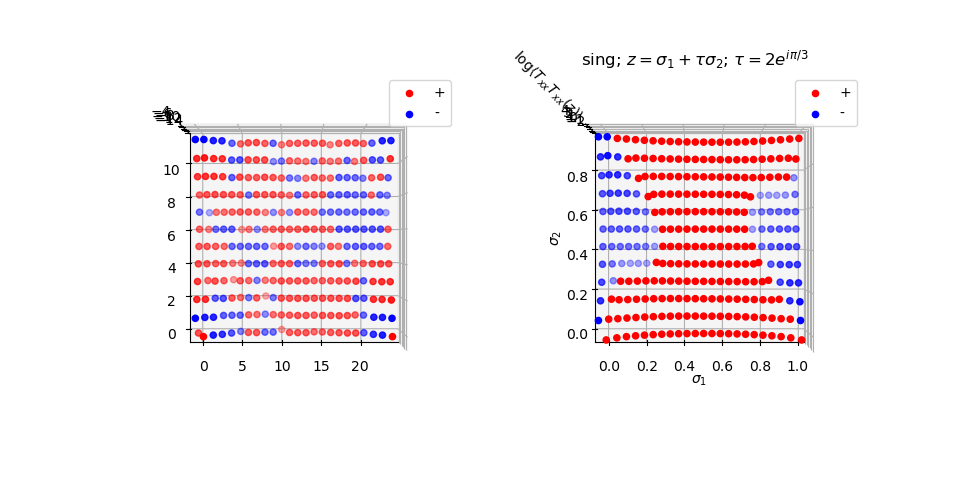

In [118]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Txxeps1.T[0], Txxeps1.T[1], np.log( Txxeps1.T[2]), c='r', marker='o', label="+")
ax.scatter(Txxeps1.T[0], Txxeps1.T[1], np.log(-Txxeps1.T[2]), c='b', marker='o', label="-")
ax.legend()

# # #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Teps_sing1.T[0], Teps_sing1.T[1], np.log(np.real(Teps_sing1.T[2] + Teps_L0)), 
           c='r', marker='o', label="+")
ax.scatter(Teps_sing1.T[0], Teps_sing1.T[1], np.log(-np.real(Teps_sing1.T[2] + Teps_L0)), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("sing; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

# plt.savefig('./Txxss.pdf',bbox_inches='tight')

In [116]:
t = 0 #  int(Ly/68)-1
yt = Txxeps1[t*Lx:(t+1)*Lx]

/tmp/ipykernel_9834/3066522110.py:11: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/tmp/ipykernel_9834/3066522110.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


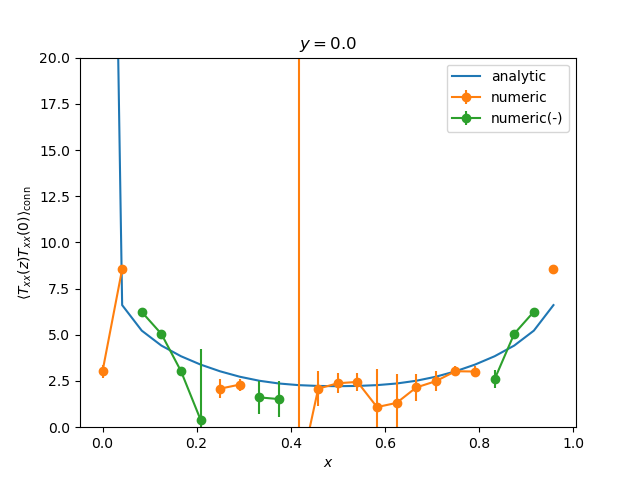

In [117]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [Teps_sing( xx + tau*t/Ly ) + Teps_L0 for xx in x] )
plt.plot( x, np.log( np.real(2.0*y) ), label="analytic" )


fac = 2.0*np.pi/r**2 * (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

plt.show()

# plt.savefig('./yslice.pdf',bbox_inches='tight')

## CHECK

In [50]:
# Nbintot=120
# nskip = 20
# Nbin = Nbintot-nskip

KA = np.array([np.loadtxt(directory1+"KA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KB = np.array([np.loadtxt(directory1+"KB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KC = np.array([np.loadtxt(directory1+"KC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

FileNotFoundError: ./data_Lx9Ly12nu1/KA_1.dat not found.

In [57]:
t0 = KA - tanhbeta*B
jk = Jackknife( Nbin, binsize, t0[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.292603(21)'

In [58]:
t1 = KB - tanhbeta*B
jk = Jackknife( Nbin, binsize, t1[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.291102(21)'

In [59]:
t2 = KC - tanhbeta*B
jk = Jackknife( Nbin, binsize, t2[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.291001(20)'

In [60]:
tmp = t1+t2-2.0*t0
jk = Jackknife( Nbin, binsize, tmp[nskip:] )
format_print( jk.mean(), jk.err() )

'-0.003103(30)'

In [61]:
tmp = t2-t1
jk = Jackknife( Nbin, binsize, tmp[nskip:] )
format_print( jk.mean(), jk.err() )

'-0.000101(16)'

In [62]:
Txx_1pt = (2.0*np.pi) * 1.0/3.0 * (2.0*t0-t1-t2)/alat/r**2
Txy_1pt = (2.0*np.pi) * 1.0/np.sqrt(3.0) * (t2-t1)/alat/r**2
jk_xx = Jackknife( Nbin, binsize, Txx_1pt[nskip:] )
jk_xy = Jackknife( Nbin, binsize, Txy_1pt[nskip:] )
print(format_print( jk_xx.mean(), jk_xx.err()  ) )
print(format_print( jk_xy.mean(), jk_xy.err()  ) )

0.2026(20)
-0.0114(18)


In [63]:
analy = T_1pt_analytic()

In [68]:
print("Re T", format_print( 0.5*jk_xx.mean(), 0.5*jk_xx.err() ), analy.real )
print("Im T", format_print( -0.5*jk_xy.mean(), 0.5*jk_xy.err() ), analy.imag )

Re T 0.10132(99) 0.1075772266133182
Im T 0.00569(91) 0.006923613578085176
